<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/age1SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=4ac4fd60a3a59fae4da4255509907024b02df3836b0a4da5dcdb26bdace3dc81
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


Data Preparation

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("agemergednormalized_with_winners_cleaned2024.csv")
data = data.drop(columns=['Aged 15 years and under'])

filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative', 'Liberal Democrat'])]
filtered_data = filtered_data.reset_index(drop=True)


party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    'Liberal Democrat': (0.98, 0.6, 0.1),  # Orange
    #'Green': (0, 0.6, 0.3),         # Dark Green
    #'The Brexit Party': (0.6, 0.2, 0.8) #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)

#Feature Scaling
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(data[features])

robust_scaler = RobustScaler()
normalized_features = robust_scaler.fit_transform(features)



normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = filtered_data[labeling_columns]

print(normalized_df.head())
print(normalized_df.shape[0])
print(normalized_df.isnull().sum())

   Aged 16 to 24 years  Aged 25 to 34 years  Aged 35 to 49 years  \
0             0.047411             0.930516             0.637784   
1            -0.139980            -0.487429            -0.532202   
2            -0.482143            -0.898048             0.922789   
3            -0.233176            -0.128767            -0.433382   
4            -0.798324            -1.434943            -0.780898   

   Aged 50 to 64 years  Aged 65 years and over  \
0            -0.358470               -0.474536   
1             0.434121                0.576412   
2            -0.172268               -0.014867   
3             0.584693                0.429415   
4             0.907584                1.320384   

  Westminster Parliamentary constituencies Winning Party  Winning Vote Share  
0                                aldershot        Labour            0.407136  
1                       aldridgebrownhills  Conservative            0.388663  
2                 altrincham and sale west        Lab

Modelling(Trainning) showing the Qe

In [7]:
# import math
# Initialize and Train SOM
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))
# n_neurons = int(math.ceil(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.3403, learning_rate=0.458,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)

# Train the SOM
num_iterations = 7500
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





 [ 7500 / 7500 ] 100% - 0:00:00 left 
 quantization error: 0.33236698182373847


Topographic Error

In [8]:
def topographic_error(som, data):
    error_count = 0
    for x in data:
        bmu = som.winner(x)
        distances = np.linalg.norm(som.get_weights() - x, axis=2)
        second_bmu = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)

        if abs(bmu[0] - second_bmu[0]) > 1 or abs(bmu[1] - second_bmu[1]) > 1:
            error_count += 1
    return error_count / len(data)

te = topographic_error(som, normalized_features)
print(f"Topographic Error: {te}")

Topographic Error: 0.09366391184573003


Visualising the BMU clustering using a U*-matrix.

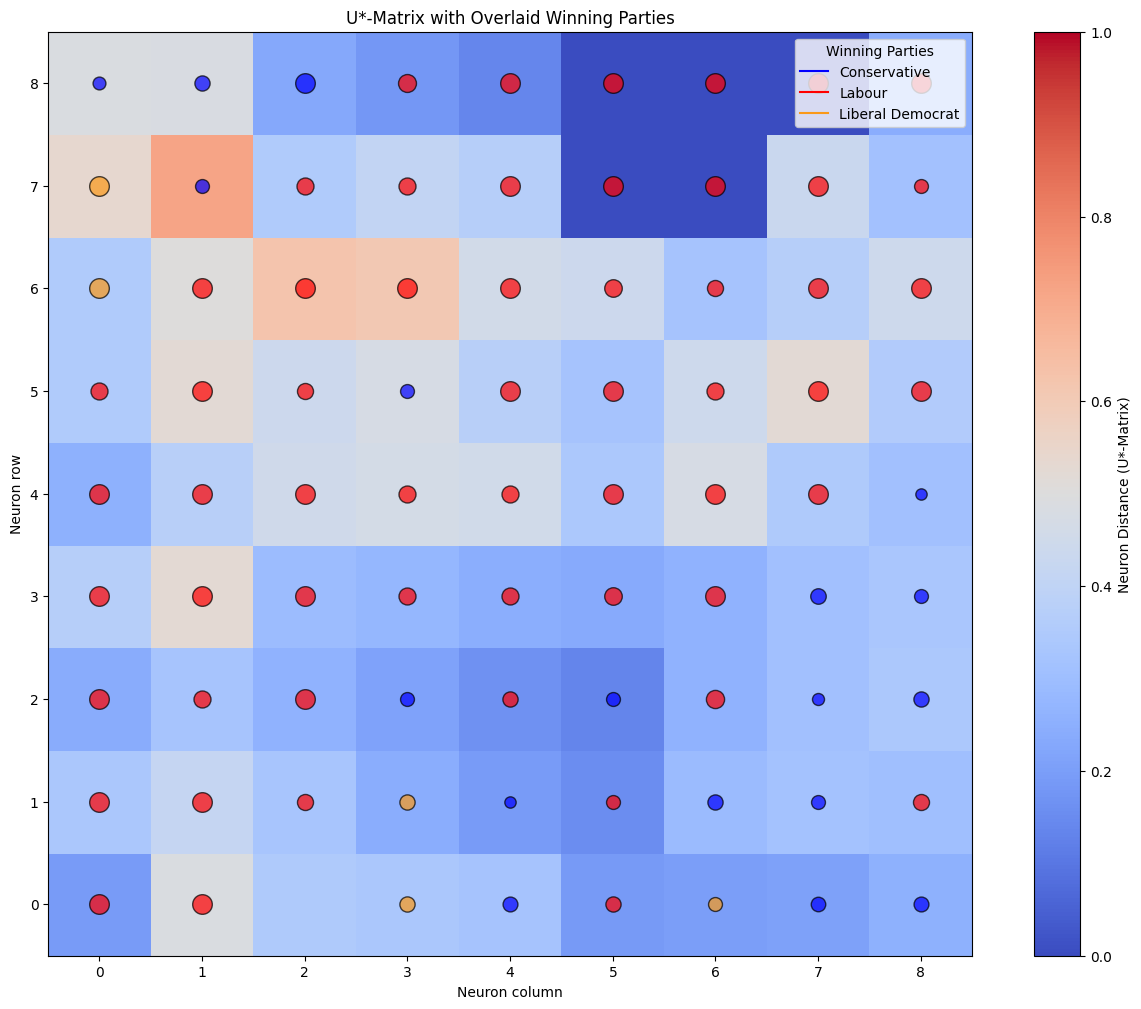

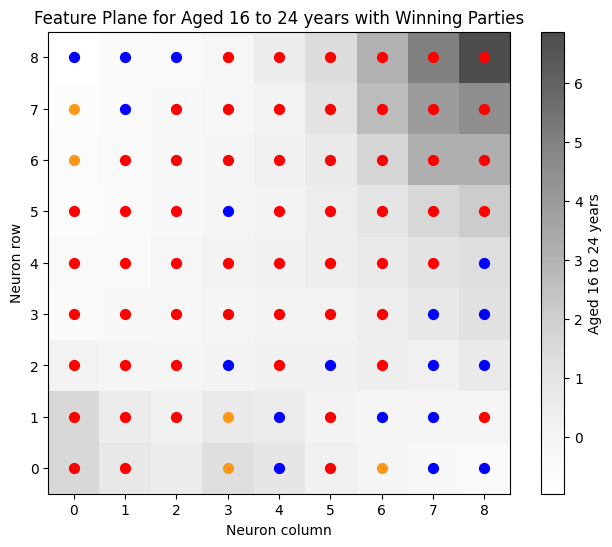

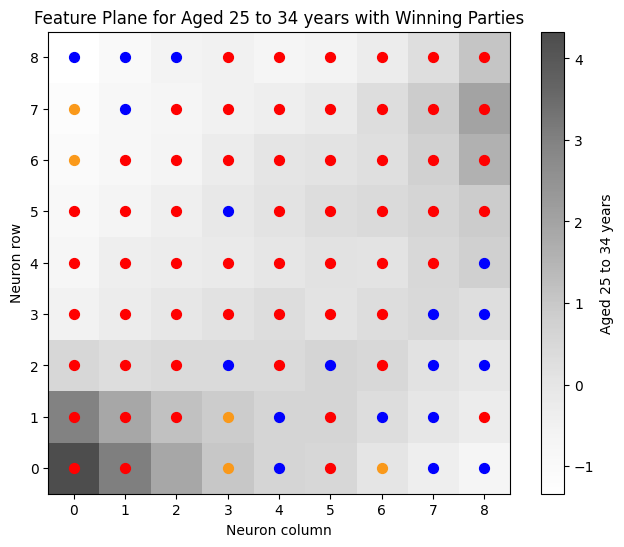

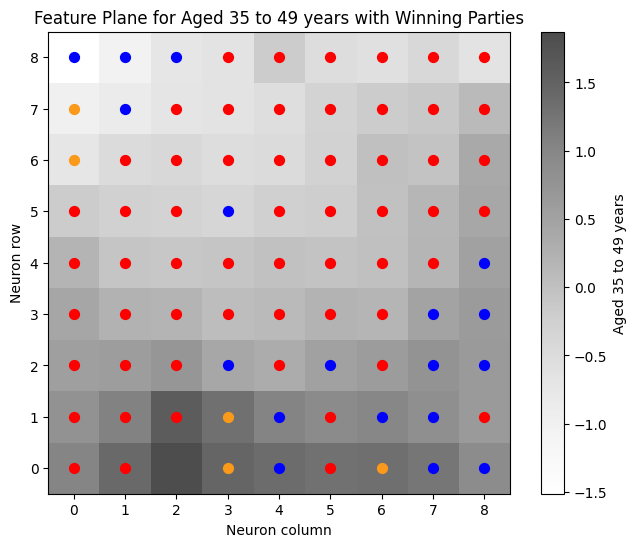

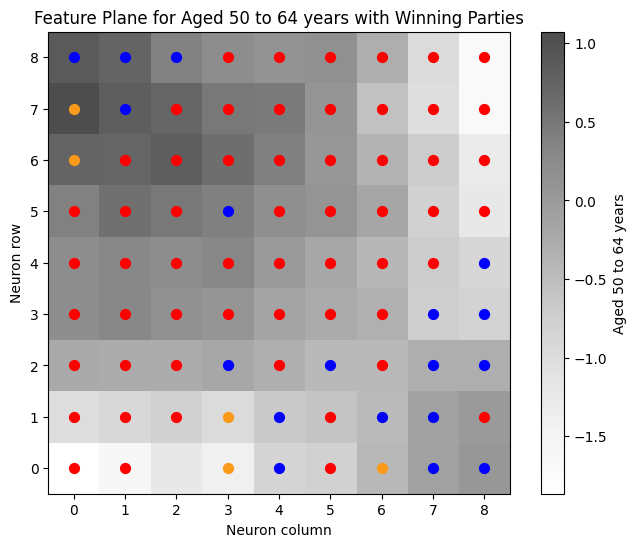

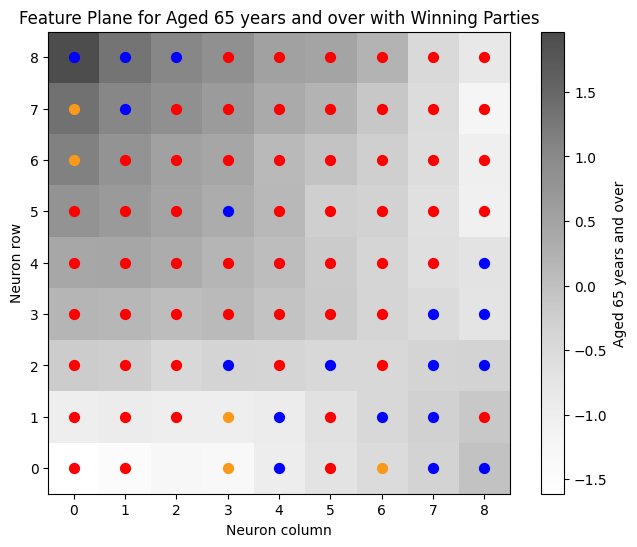

Neuron (5, 2): ['aldershot', 'harlow', 'romford']
Neuron (3, 7): ['aldridgebrownhills', 'gosport', 'havant', 'hereford and south herefordshire', 'middlesbrough south and east cleveland', 'morecambe and lunesdale', 'south holland and the deepings', 'south west norfolk']
Neuron (8, 0): ['altrincham and sale west', 'epsom and ewell', 'esher and walton', 'maidenhead', 'ruislip northwood and pinner', 'south west hertfordshire', 'windsor']
Neuron (3, 6): ['amber valley', 'barrow and furness', 'bassetlaw', 'hastings and rye', 'north durham']
Neuron (0, 7): ['arundel and south downs', 'beverley and holderness', 'derbyshire dales', 'hexham', 'north dorset', 'skipton and ripon', 'south east cornwall', 'st ives', 'thirsk and malton', 'west worcestershire', 'westmorland and lonsdale']
Neuron (4, 4): ['ashford', 'bury north', 'old bexley and sidcup', 'stokeontrent south']
Neuron (5, 5): ['ashtonunderlyne', 'bootle', 'kingston upon hull east', 'knowsley', 'liverpool west derby']
Neuron (2, 2): ['ayl

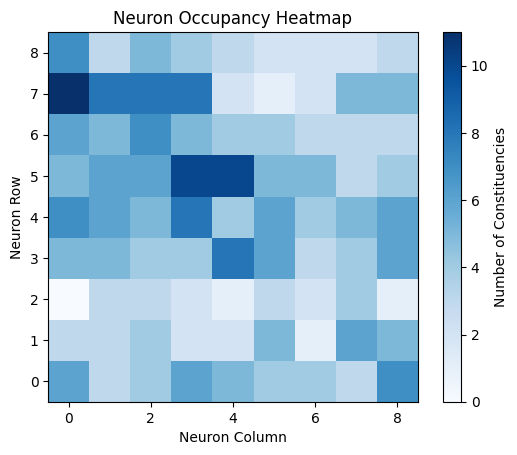

In [11]:
#U*-Matrix plotting implementation(Combination of a density matrix and distance matrix)
from scipy.ndimage import median_filter

# This process was emulated from a cited paper within the report of the u*-matrix

#This is the distance based matrix
u_matrix = som.distance_map()
#plotting the two dimensional grid
density_matrix = np.zeros((n_neurons, m_neurons))

for r, c in zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']):
    density_matrix[r, c] += 1  # Count occurrences of the data points in each neuron

# Normalize density values to avoid division errors(anomalies and smoothen density matrix)
density_matrix = median_filter(density_matrix, size=3)  # Avoid division by zero (Laplace smoothing)

# Computing the scale factor to be multiplied with distance based(u-matrix) leading to the U*-Matrix
min_p = np.min(density_matrix)
mean_p = np.mean(density_matrix)

if mean_p - min_p == 0:
    scale_factor = np.ones_like(density_matrix)
else:
    scale_factor = (density_matrix - min_p) / (mean_p - min_p)
u_star_matrix = u_matrix * scale_factor

#Plotting of the neurons based on the party with the most party vote share in the neuron
# party_counts = (normalized_df
#                 .pivot_table(index=['Neuron Row', 'Neuron Col'],
#                 columns = 'Winning Party',
#                 values = 'Winning Vote Share',
#                 aggfunc = 'sum',
#                 fill_value=0))

#Plotting of the neurons based on the party with the most constitueny count
party_counts = (normalized_df
                .groupby(['Neuron Row', 'Neuron Col', 'Winning Party'])
                .size()
                .unstack(fill_value=0))

dominant = party_counts.idxmax(axis=1)                # party with most seats
share    = party_counts.max(axis=1) / party_counts.sum(1)  # its proportion

labels_df = pd.concat([dominant.rename('major_party'),
                       share.rename('purity')], axis=1)
labels_df.to_csv('NeuronPurity.csv')

#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U*-Matrix with Overlaid Winning Parties")
plt.imshow(u_star_matrix.T, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
plt.colorbar(label="Neuron Distance (U*-Matrix)")
# Overlayying the winning parties on the neurons
for (r, c), party in dominant.items():
    if party in party_colors:
        base_color = np.array(party_colors[party])
        plt.scatter(c,#neuron_row #+ 0.3 * np.random.rand(),
                    r,# neuron_col, #+ 0.3 * np.random.rand(),
                    s=200*share.loc[(r,c)],
                    color= base_color,#adjusted_color,
                    alpha=0.7, edgecolors='k',)

# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron column")
plt.ylabel("Neuron row")
plt.show()

for feature_name in features.columns:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane.T, cmap='Greys', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {features.columns[feature_index]} with Winning Parties")
    plt.xlabel("Neuron column")
    plt.ylabel("Neuron row")

    # for index, row in normalized_df.iterrows():
    for (r, c), party in dominant.items():
        # neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
        # winning_party = row['Winning Party']
        colour = np.array(party_colors[party])
        if party in party_colors:
          plt.scatter(c, r, color=colour, marker='o', s=50)

    plt.show()

# Neuron-Constituency Mapping for cluster analysis and understanding
neuron_constituency_map = {}
for index, row in normalized_df.iterrows():
    neuron = (row['Neuron Row'], row['Neuron Col'])
    constituency = row['Westminster Parliamentary constituencies']
    if neuron not in neuron_constituency_map:
        neuron_constituency_map[neuron] = []
    neuron_constituency_map[neuron].append(constituency)

# Print the constituencies mapped to each neuron (optional)
for neuron, constituencies in neuron_constituency_map.items():
    print(f"Neuron {neuron}: {constituencies}")




normalized_df['Neuron'] = list(zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']))
# Party Distribution of the winning neurons with its vote share dataset for analysis
grouped = normalized_df.groupby("Neuron").agg({
    'Winning Party': lambda x: x.value_counts().to_dict(),
    'Winning Vote Share': 'mean',
}).rename(columns={
    'Winning Party': 'Party Distribution',
    'Winning Vote Share': 'Avg Vote Share',
})

print(grouped.head())

grouped.to_csv('neuron_party_distribution.csv')

from matplotlib import pyplot as plt

hit_map = np.zeros((som._weights.shape[0], som._weights.shape[1]))
for x in normalized_features:
    bmu = som.winner(x)
    hit_map[bmu] += 1

plt.imshow(hit_map.T, cmap='Blues', origin='lower')
plt.colorbar(label='Number of Constituencies')
plt.title('Neuron Occupancy Heatmap')
plt.xlabel('Neuron Column')
plt.ylabel('Neuron Row')
plt.show()




In [12]:
valley_cells = {(8,5), (8,6), (8,7), (7,5), (7,6)}

valley_df = normalized_df[
    normalized_df.apply(
        lambda r: (r['Neuron Row'], r['Neuron Col']) in valley_cells,
        axis=1
    )
][[
    'Westminster Parliamentary constituencies',
    'Winning Party',
    'Winning Vote Share'
]]

valley_df.to_csv("valley_constituencies.csv", index=False)
display(valley_df.head())

,Westminster Parliamentary constituencies,Winning Party,Winning Vote Share
25,birmingham ladywood,Labour,0.425326
28,birmingham yardley,Labour,0.311947
39,bradford east,Labour,0.378816
41,bradford west,Labour,0.316173
148,holborn and st pancras,Labour,0.489197


In [13]:
seat_counts  = valley_df['Winning Party'].value_counts()
purity       = seat_counts.max() / seat_counts.sum()

print("Seats by party:\n", seat_counts)
print(f"Purity = {purity:.1%}")


Seats by party:
 Winning Party
Labour    18
Name: count, dtype: int64
Purity = 100.0%


In [15]:
feature_cols = features.columns  # five age bands
valley_features = normalized_df.loc[valley_df.index, feature_cols]

# mean of the observations per age band inside the valley
valley_profile = valley_features.mean()

print(valley_features)
print(valley_profile)

     Aged 16 to 24 years  Aged 25 to 34 years  Aged 35 to 49 years  \
25              3.842721             2.322090             0.355114   
28              1.539564             0.448419             0.088562   
39              2.049082             0.354481             0.355809   
41              2.742956             0.681809             0.464969   
148             3.369552             2.167238             0.251140   
168             2.023406             0.998009             0.696692   
173             3.190957             0.772263            -0.302890   
174             5.513729             2.521870            -0.341818   
176             3.386969             0.429675            -0.138602   
185             4.228692             3.442476             0.020346   
186             4.588587             1.927108             0.354551   
223             4.351855             1.417637             0.288901   
229             2.943777             1.907082             0.566700   
234             3.23